In [10]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 15

In [1]:
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd

In [2]:

os.chdir("prepared_corpora/msrp_noun_sym_verb_anto_corruptions/")

In [5]:
def embedding_distance(embeddings, id1, id2):
    ii = id1 - 1  #Change from 1 indexed id, to 0 indexex embedding index
    jj = id2 - 1
    return scipy.spatial.distance.cosine(embeddings[ii,:], embeddings[jj,:])

In [6]:
def load_link_distances(link_filename, embeddings):
    links = np.loadtxt(link_filename, delimiter=",",skiprows=1, dtype=np.int)
    dists = pd.Series()
    for link in links:
        assert(len(link)==2)
        phrase_id = link[0]
        var_phrase_id = link[1]
        
        dists.loc[phrase_id] = embedding_distance(embeddings, phrase_id, var_phrase_id)
    return dists



In [7]:
def get_dists_table(embedding_filename, max_corruption = 10):
    embeddings = np.loadtxt(embedding_filename, delimiter=",")
    dists = pd.DataFrame()
    dists["paraphrase"] = load_link_distances("paraphrases.txt", embeddings)
    for corruption_level in range(1,max_corruption+1):
        link_filename = str(corruption_level)+"verb_anto_semantic_corruptions.txt"
        dists["verb_anto_" + str(corruption_level)] = load_link_distances(link_filename, embeddings)
        link_filename = str(corruption_level)+"noun_sym_semantic_corruptions.txt"
        dists["noun_sym_" + str(corruption_level)] = load_link_distances(link_filename, embeddings)
    return dists  
    

In [124]:
rae_dists = get_dists_table("outVectors_RAE2011.csv")
doc2vec_dists = get_dists_table("outVectors_hansard_doc2vec.csv")


/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "7verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "8verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "9verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "10verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


In [131]:
def n_closer_than_paraphrase(prefix, dists):
    """
    prefix : eg "verb_anto_" or  "noun_sym_"
    """
    return [(dists.paraphrase > dists[prefix+str(nchanges)]).sum()/dists[prefix+str(nchanges)].count() for nchanges in range(1,11)]

comparative_distances = pd.DataFrame()

comparative_distances["n_changes"] = list(range(1,11))
comparative_distances["RAE_noun_sym_lt_para"] = n_closer_than_paraphrase("noun_sym_", rae_dists)
comparative_distances["RAE_verb_anto_lt_para"] = n_closer_than_paraphrase("verb_anto_", rae_dists)
comparative_distances["doc2vec_noun_sym_lt_para"] = n_closer_than_paraphrase("noun_sym_", doc2vec_dists)
comparative_distances["doc2vec_verb_anto_lt_para"] = n_closer_than_paraphrase("verb_anto_", doc2vec_dists)
comparative_distances

,n_changes,RAE_noun_sym_lt_para,RAE_verb_anto_lt_para,doc2vec_noun_sym_lt_para,doc2vec_verb_anto_lt_para
0,1,0.953969,0.804167,0.791945,0.399405
1,2,0.909299,0.750130,0.678541,0.296104
2,3,0.869259,0.756637,0.557804,0.258850
3,4,0.833826,0.638554,0.461292,0.192771
4,5,0.797163,0.466667,0.341258,0.133333
5,6,0.758953,0.500000,0.291322,0.000000
6,7,0.739377,NaN,0.212465,NaN
7,8,0.700000,NaN,0.141935,NaN
8,9,0.675439,NaN,0.096491,NaN
9,10,0.675676,NaN,0.108108,NaN


In [132]:
def compare_sym_anto_distances(dists, max_changes=6):
    def inner():
        for nchanges in range(1,max_changes):
            verb_antos = dists["verb_anto_"+str(nchanges)]
            noun_syms =  dists["noun_sym_"+str(nchanges)]
            valid_dists = dists[np.logical_and(pd.notnull(verb_antos), pd.notnull(noun_syms))]
            yield (verb_antos > noun_syms).sum()/len(valid_dists)
    return list(inner())

comparative_distances["doc2vec_noun_sym_lt_verb_anto"] = compare_sym_anto_distances(doc2vec_dists)
comparative_distances["RAE_noun_sym_lt_verb_anto"] = compare_sym_anto_distances(rae_dists)

ValueError: Length of values does not match length of index

In [71]:
def drop_null_cols(df):
    keep_cols = [col for col in df.columns if not(all(pd.isnull(df.loc[:,col])))]
    return df.loc[:,keep_cols]
    
rae_dists_nn = drop_null_cols(rae_dists)
doc2vec_dists__ = drop_null_cols(doc2vec_dists)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb73a54deb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb73a250080>]], dtype=object)

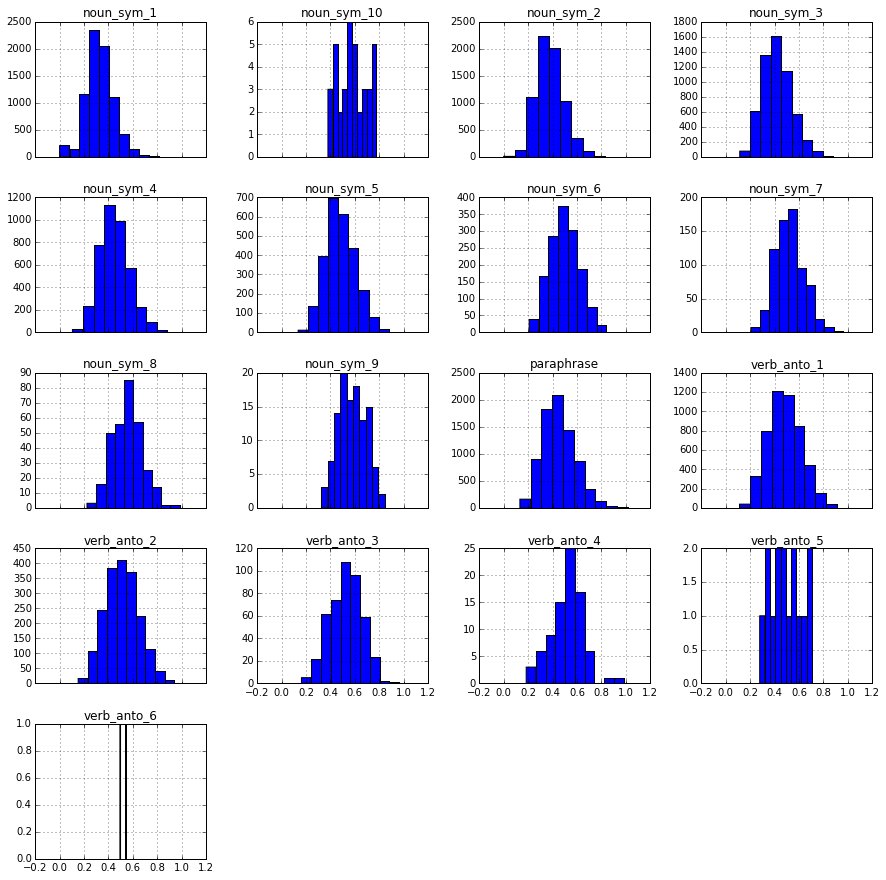

In [77]:
doc2vec_dists.hist(sharex=True)

[0.87734895938573454,
 0.87681970884658456,
 0.89355742296918772,
 0.94117647058823528,
 1.0]

[0.97049909072539908,
 0.9585666293393057,
 0.95798319327731096,
 0.96078431372549022,
 1.0]

In [106]:
pd.notnull(False)

True

149600000000.0